In [102]:
import json
import os

results_dir = "results/"
json_files = [pos_json for pos_json in os.listdir(results_dir) if pos_json.endswith('.json')]

data = []
for index, json_fn in enumerate(json_files):
    with open(os.path.join(results_dir, json_fn)) as in_file:
        fusion_group = json_fn.removesuffix('.json')
        content = json.load(in_file)
        data.extend(content)

In [103]:
# This is a single invocation
# data[0]

In [104]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

df = pd.DataFrame.from_dict(data)

# Get the smallest Start timestamp and remove it from every timestamp value
min_start_timestamp = df["startTimestamp"].min()
df["startTimestamp"] = df["startTimestamp"] - min_start_timestamp
df["endTimestamp"] = df["endTimestamp"] - min_start_timestamp
df["duration"] =  df["endTimestamp"] - df["startTimestamp"]

df

,traceId,fusionGroup,source,currentFunction,billedDuration,maxMemoryUsed,isRootInvocation,startTimestamp,endTimestamp,internalDuration,calls,duration
0,caaf0746ffc248b2e188695272225c5b79873b9ce2ca7e...,"A.B.C.D.E.F,G",A,A,4987,101,True,52828,57813,4983,"[{'called': 'F', 'caller': 'A', 'local': True,...",4985
1,72b7ec25454ffd550434524344f144bb98320217859a8a...,"A.B.C.D.E.F,G",A,A,4150,121,True,58382,62532,4149,"[{'called': 'F', 'caller': 'A', 'local': True,...",4150
2,f64aa6803a83f663d1ee90b191798f4c47f7b8773deed5...,"A.B.C.D.E.F,G",A,A,5056,101,True,57898,62947,5047,"[{'called': 'F', 'caller': 'A', 'local': True,...",5049
3,3d2b23abf158d7abbc7caeb75868bda613c233bcdc16bb...,"A.B.C.D.E.F,G",A,A,4211,119,True,63373,67583,4209,"[{'called': 'F', 'caller': 'A', 'local': True,...",4210
4,3af7fc8e7ce13901cee20a9b9c4e957fddb27d33437021...,"A.B.C.D.E.F,G",A,A,3611,120,True,69414,73023,3608,"[{'called': 'F', 'caller': 'A', 'local': True,...",3609
...,...,...,...,...,...,...,...,...,...,...,...,...
1370,1ecd1c9a2355bf8e4299c75e6c76c62104c35da2e2c8a3...,"A.B.D,C,E,F,G",A,A,3073,82,True,279166,282238,3071,"[{'called': 'C', 'caller': 'A', 'local': False...",3072
1371,1ecd1c9a2355bf8e4299c75e6c76c62104c35da2e2c8a3...,"A.B.D,C,E,F,G",A,C,814,113,False,279275,280088,812,"[{'called': 'F', 'caller': 'C', 'local': False...",813
1372,1ecd1c9a2355bf8e4299c75e6c76c62104c35da2e2c8a3...,"A.B.D,C,E,F,G",A,E,1004,78,False,279228,280231,1002,"[{'called': 'E', 'caller': 'E', 'local': True,...",1003
1373,1ecd1c9a2355bf8e4299c75e6c76c62104c35da2e2c8a3...,"A.B.D,C,E,F,G",A,F,1197,91,False,280610,281792,1140,"[{'called': 'F', 'caller': 'F', 'local': True,...",1182


In [105]:
print(f'Unique Invocations: {df["traceId"].nunique()}')

Unique Invocations: 360


<AxesSubplot:ylabel='billedDuration'>

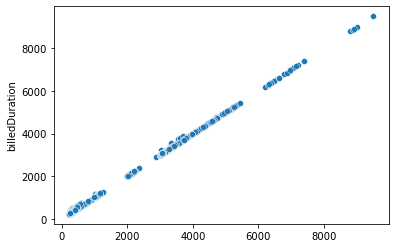

In [106]:
sns.scatterplot(data=df, x=df["endTimestamp"]-df["startTimestamp"], y="billedDuration")

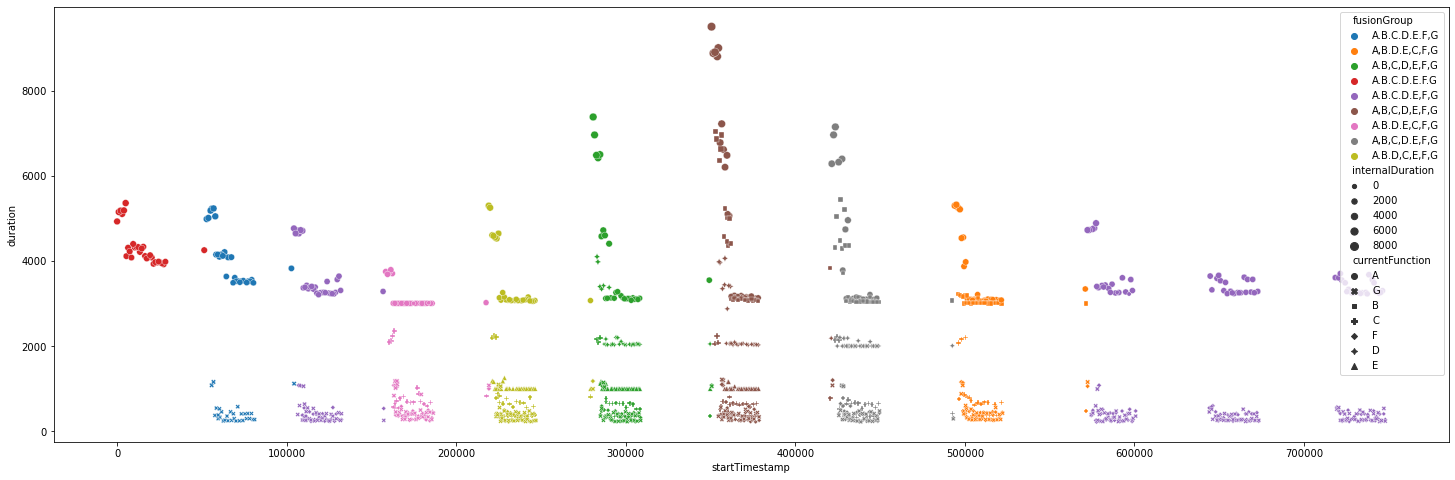

In [107]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=df, x="startTimestamp", y="duration", size="internalDuration", hue=df["fusionGroup"], style="currentFunction")
plt.savefig("pointCloud.pdf")

<AxesSubplot:xlabel='startTimestamp', ylabel='10s_billedDuration_avg'>

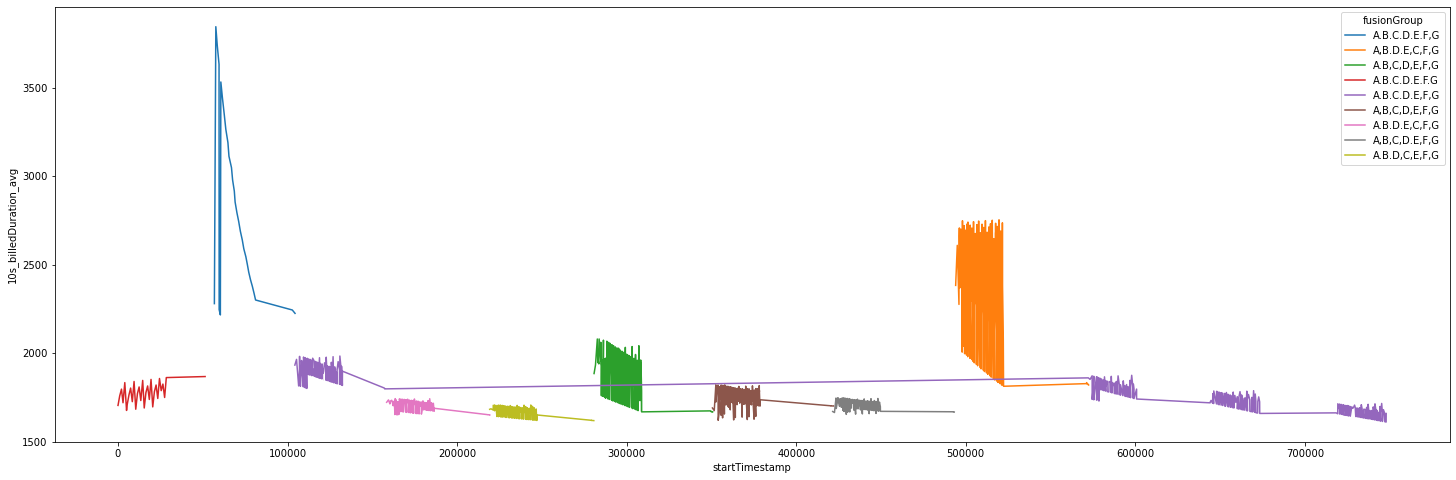

In [108]:
plt.figure(figsize=(25,8))
df['10s_billedDuration_avg'] = df['billedDuration'].rolling(10000, min_periods=30).mean()
#df['10s_billedDuration_med'] = df['billedDuration'].rolling(10000, min_periods=30).median()
sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_avg", hue=df["fusionGroup"])
#sns.lineplot(data=df, x="startTimestamp", y="10s_billedDuration_med", hue=df["fusionGroup"])
#sns.scatterplot(data=df, x="startTimestamp", y="billedDuration", hue=df["fusionGroup"], legend=None)

In [109]:
# Now do not count every invocation, but sort the df by the cost of trace
grouped = df.groupby('traceId').agg({'billedDuration': ['sum'], 'startTimestamp': ['min'], 'endTimestamp': ['max'], 'fusionGroup': 'min'})
#grouped['numInvocations'] = df.groupby('traceId').count()
grouped['numInvocations'] = df.groupby('traceId').size()
print(f'Total Number of Invocations should be: {grouped["numInvocations"].sum()} == {len(df.index)}')

# Grouped: Get Root Invocation of TraceId and get rootEndTimestamp
# Pandas join() oder merge() machen mit dem alten Dataframe. Merge ist einfacher
rootInvocations = df[df["isRootInvocation"]][["traceId", "endTimestamp"]].rename(columns={"endTimestamp": "rootEndTimestamp"})
grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")
grouped["rootDuration"] = grouped["rootEndTimestamp"] - grouped["startTimestamp", "min"]

grouped

Total Number of Invocations should be: 1375 == 1375


/tmp/ipykernel_21038/2807751757.py:10: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  grouped = pd.merge(grouped, rootInvocations, how="left", on="traceId")


,traceId,"(billedDuration, sum)","(startTimestamp, min)","(endTimestamp, max)","(fusionGroup, min)","(numInvocations, )",rootEndTimestamp,rootDuration
0,00df034055ff95de2826528fa235f3e1fb741732f5f62b...,3820,127835,131062,"A.B.C.D.E,F,G",3,131062.0,3227.0
1,01526358144d8bff57a1be5c00eee26e1a3b9fba40dcbb...,4213,13440,17653,A.B.C.D.E.F.G,1,17653.0,4213.0
2,015b307ca5ea66279e6d73319b88e22ff540f630dac66e...,7313,367200,370314,"A,B,C,D,E,F,G",6,NaN,NaN
3,02793f88bb7625ec437ac0b2c67be5b737bb8603b04f07...,4081,20478,24558,A.B.C.D.E.F.G,1,24558.0,4080.0
4,02d12cbc29ff67d7b26d96f24d469d5beda0aedfd9d9a1...,8859,285655,290234,"A.B,C,D,E,F,G",6,290234.0,4579.0
...,...,...,...,...,...,...,...,...
355,fddc6d917512f8122278a57bcadce92af0497248d999d1...,4145,652722,656027,"A.B.C.D.E,F,G",3,656027.0,3305.0
356,fdfcad402775dc2d68ee840fc14d52d8287729d172b0e2...,282,727657,727938,"A.B.C.D.E,F,G",1,NaN,NaN
357,fee7fe27285b36e24a793e14183611e3e2f500ea0cbb7a...,4001,121832,125095,"A.B.C.D.E,F,G",3,125095.0,3263.0
358,ff0124541dec8bae9a7d60482c1f2d43086893362e563f...,3782,589820,593085,"A.B.C.D.E,F,G",3,593085.0,3265.0


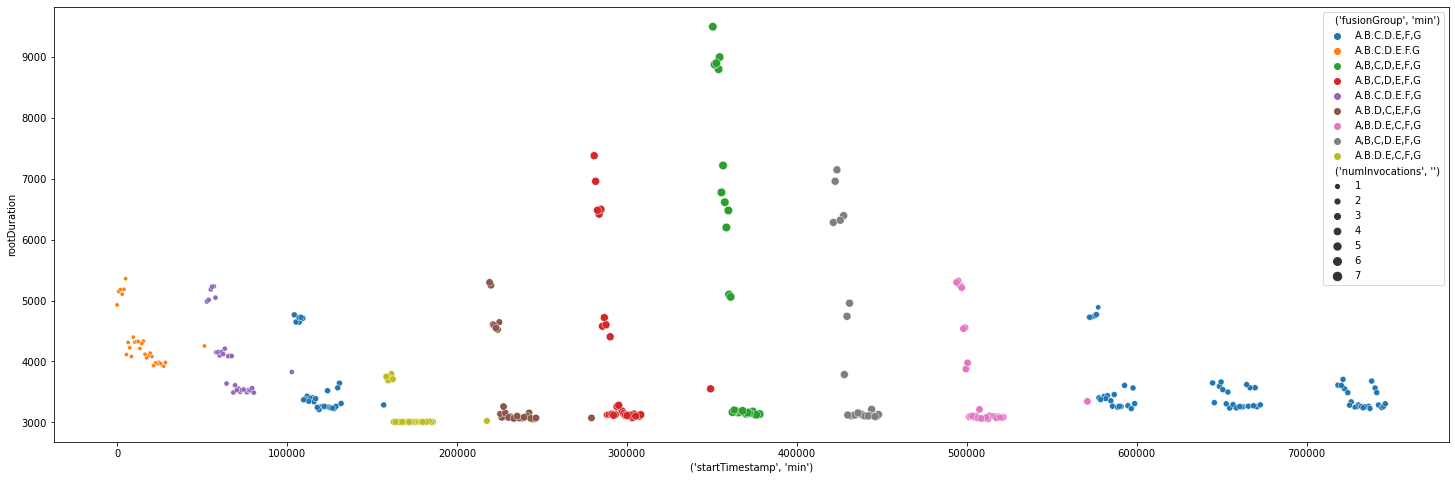

In [110]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['rootDuration'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("duration.pdf")

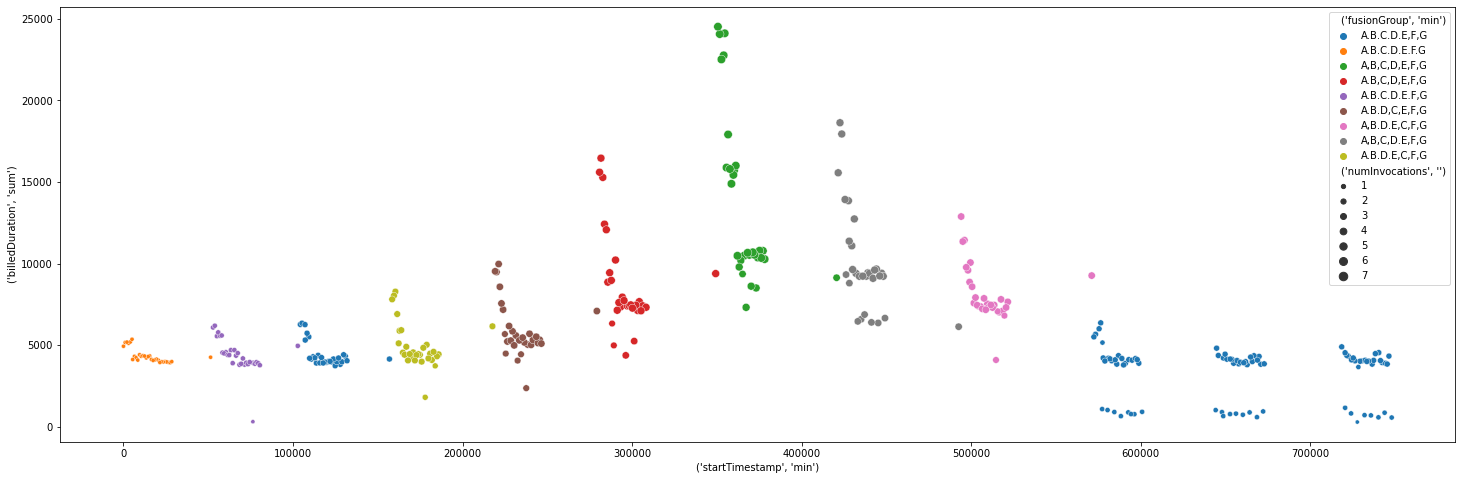

In [111]:
plt.figure(figsize=(25,8))
sns.scatterplot(data=grouped, x=grouped['startTimestamp', 'min'] , y=grouped['billedDuration', 'sum'], hue=grouped['fusionGroup', 'min'], size=grouped["numInvocations", ""])
plt.savefig("billed.pdf")

['A.B.C.D.E.F.G' 'A.B.C.D.E.F,G' 'A.B.C.D.E,F,G' 'A.B.D.E,C,F,G'
 'A.B.D,C,E,F,G' 'A.B,C,D,E,F,G' 'A,B,C,D,E,F,G' 'A,B,C,D.E,F,G'
 'A,B.D.E,C,F,G']


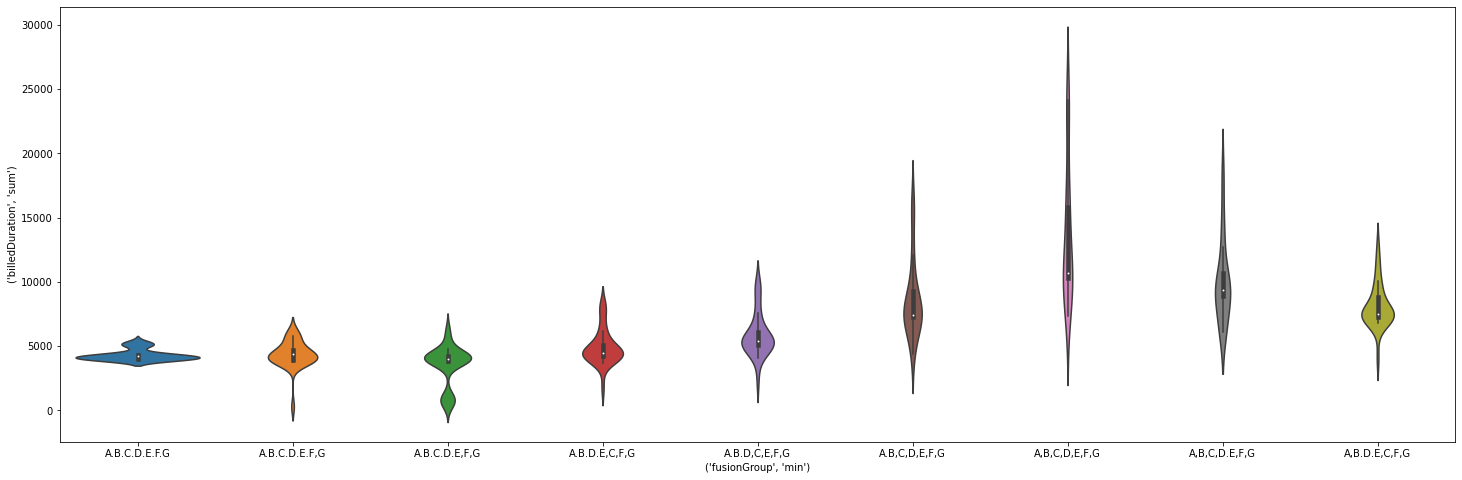

In [112]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['billedDuration', 'sum'], order=fusion_groups_order)
plt.savefig("violinBilled.pdf")

['A.B.C.D.E.F.G' 'A.B.C.D.E.F,G' 'A.B.C.D.E,F,G' 'A.B.D.E,C,F,G'
 'A.B.D,C,E,F,G' 'A.B,C,D,E,F,G' 'A,B,C,D,E,F,G' 'A,B,C,D.E,F,G'
 'A,B.D.E,C,F,G']


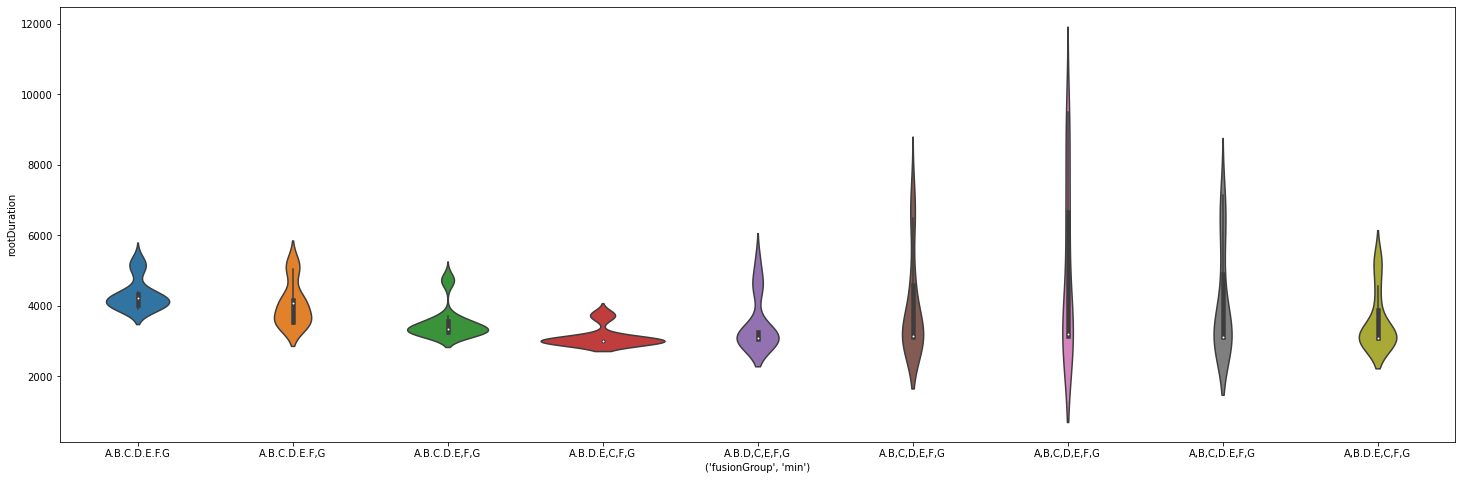

In [113]:
plt.figure(figsize=(25,8))
fusion_groups_order = pd.unique(grouped.sort_values(by="rootEndTimestamp")['fusionGroup', 'min'])
print(fusion_groups_order)
sns.violinplot(data=grouped, x=grouped['fusionGroup', 'min'] , y=grouped['rootDuration'], order=fusion_groups_order)
plt.savefig("violinRR.pdf")